# EDA AND PREPROCESSING
## Data Loading

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import math
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8836723019665042944,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9894756352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15580258556732006194
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [4]:
path = r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data'

file_list = os.listdir(path)[2:]
assert len(file_list) == 10
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [5]:
#Normal[label 0] → Fault-free operating condition
#Unbalance[label 1] → Unbalance between centers of mass and axis
#Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
#Belt-Looseness High[label 3] → High Looseness of V-belt
#Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

In [6]:
print(
    train_1st_Normal.shape,
    train_1st_Bearing.shape,
    train_1st_Looseness.shape,
    train_1st_Unbalance.shape,
    train_1st_high.shape,
    train_2nd_Bearing.shape,
    train_2nd_Looseness.shape,
    train_2nd_Unbalance.shape,
    train_3rd_Normal.shape,
    train_3rd_Unbalance.shape
)

(6421296, 2) (18979200, 2) (4384196, 2) (15657840, 2) (11779756, 2) (41020378, 2) (32365862, 2) (30082032, 2) (52907684, 2) (23616452, 2)


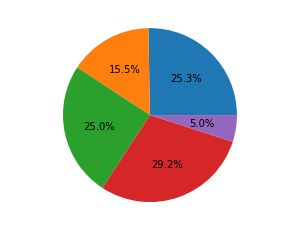

In [7]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('white') 
    items.set_fontsize('14')

plt.show()

## Dataset Construction/Augmentation and Solving Class Imbalance Problem

In [152]:
# window augmentaion
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out
  Number_of_samples = int(df.shape[0] / window)-30
  data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel)) # Defines input shape 
  label = np.full_like(np.zeros((Number_of_samples)), label) # label을 포함한 배열로 만들어줌 
  for i in tqdm(range(Number_of_samples)):
    data_array[i]= df.iloc[window * i : window * i + time_series_length,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array, label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_samples = int(df.shape[0] / time_series_length)-48
  data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_samples)), label)
  for i in range(Number_of_samples):
    data_array[i]= df.iloc[window * i : window * i + time_series_length,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array, label))
  return ds 

In [58]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4)
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 30)
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4)
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184473/184473 [00:07<00:00, 25570.11it/s]


1809 1830 1594 2114 1533


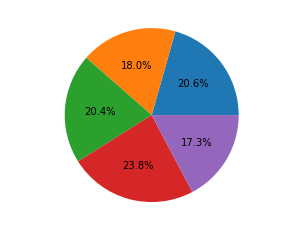

In [60]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('white') 
    items.set_fontsize('14')
print(normal, bearing, looseness, unbalance, high)
plt.show()

In [107]:
batchsize = 256
epochs = 20

sub = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\sample_submission_classification - 복사본.csv')
final = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\final.csv').iloc[:,1:]

In [61]:
Dataset = (
    Bearing1st_ds.concatenate(Looseness1st_ds)
                        .concatenate(Normal1st_ds)
                        .concatenate(Unbalance1st_ds)
                        .concatenate(High1st_ds)
                        .concatenate(Bearing2nd_ds)
                        .concatenate(Looseness2nd_ds)
                        .concatenate(Unbalance2nd_ds)
                        .concatenate(Normal3rd_ds)
                        .concatenate(Unbalance3rd_ds)
                        .shuffle(buffer_size = 4518720, seed = 42)
                        .batch(batchsize, drop_remainder=True)
                        .prefetch(1)
)

# Most dataset input pipelines should end with a call to prefetch. 
# This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements. 

In [62]:
Dataset.__len__().numpy()

8880

In [95]:
Valid_Dataset = Dataset.take(1800) # Creates a Dataset with at most count elements from this dataset.
Train_Dataset = Dataset.skip(1800) # Creates a Dataset that skips count elements from this dataset.

In [108]:
print(Train_Dataset.cardinality)
print(Valid_Dataset.cardinality)

<bound method DatasetV2.cardinality of <SkipDataset shapes: ((256, 128, 2), (256,)), types: (tf.float64, tf.float64)>>
<bound method DatasetV2.cardinality of <TakeDataset shapes: ((256, 128, 2), (256,)), types: (tf.float64, tf.float64)>>


# VISUALIZATION

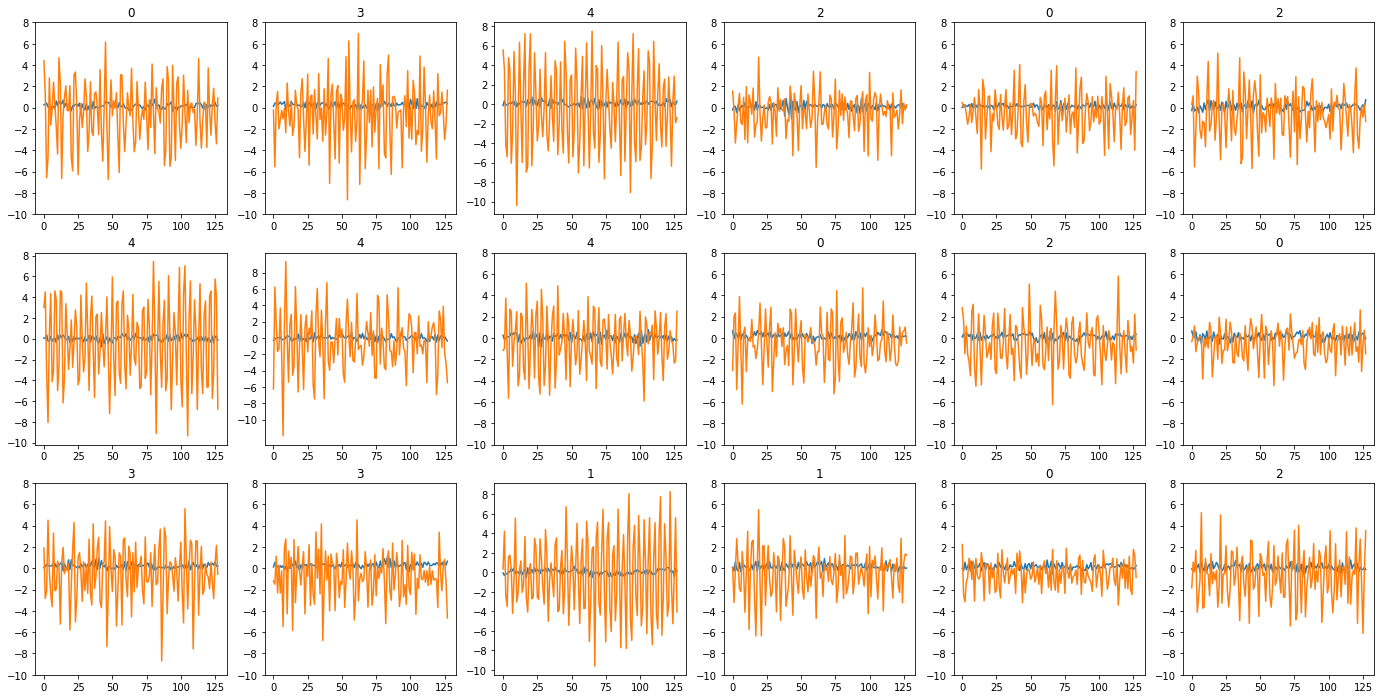

In [16]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

# Fast Fourier Transform and Continuous Wavelet Transform

In [17]:
Sample = list(Train_Dataset.unbatch().take(1000).as_numpy_iterator())[0][0]

In [18]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

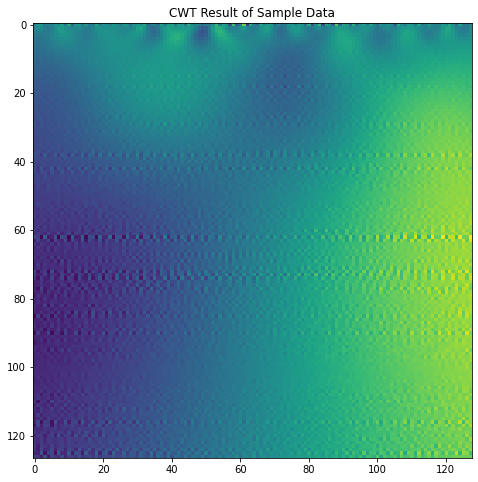

In [19]:
import pywt
from scipy import fftpack
# fft : 신호 데이터셋에서 시간 정보를 없애므로 정보 손실 발생하는 단점이 존재함.
# wavelet transform - wavelet을 filter로서 사용

coef, freqs = pywt.cwt(Sample ,np.arange(1,128), 'gaus1' , axis = 0)

fig = plt.figure()
fig.set_size_inches(8, 8)
plt.title("CWT Result of Sample Data")
plt.imshow(coef[:,:,0])

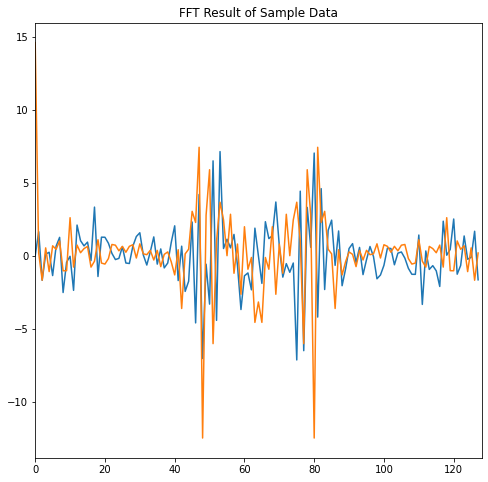

In [20]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.figure().set_size_inches(8, 8)
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

# CUSTOM MODELING

## Callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,  # minimum value to determine 'improved'
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)
reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=5,
    cooldown=1, 
    min_delta=0.0001,   
    mode='min',
    verbose=1
)
tensorboard = TensorBoard(
    log_dir = 'logs',
    update_freq='epoch',
    write_images=False
)
callbacks = [earlystop, reducelr, tensorboard]

In [22]:
%load_ext tensorboard

In [23]:
'''
import wandb
from wandb.keras import WandbCallback

wandb.init(project='TNT', entity='obeychoi',
            config = {
                "learning_rate" : 0.01,
                "epochs" : 10,
                "batch_size" : 128,
                "loss_function" : "sparse_categorical_crossentropy",
                "metric" : "sparse_categorical_accuracy"
            })
config = wandb.config
callback = WandbCallback(monitor = 'val_sparse_categorical_accuracy')
tf.keras.backend.clear_session()
'''

'\nimport wandb\nfrom wandb.keras import WandbCallback\n\nwandb.init(project=\'TNT\', entity=\'obeychoi\',\n            config = {\n                "learning_rate" : 0.01,\n                "epochs" : 10,\n                "batch_size" : 128,\n                "loss_function" : "sparse_categorical_crossentropy",\n                "metric" : "sparse_categorical_accuracy"\n            })\nconfig = wandb.config\ncallback = WandbCallback(monitor = \'val_sparse_categorical_accuracy\')\ntf.keras.backend.clear_session()\n'

# CLSTM
## 0. Vanilla CLSTM

In [24]:
# he normalization paper https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
# Convolution(or FC) - Batch Normalization - Activation - Dropout - Pooling 순서대로 네트워크를 구현하는 것이 바람직
# batchnorm(x) =  gamma * normalized(x) + bias 
# 즉 batchnorm에 bias가 포함되어 있으므로 conv층에서 use bias = False로 설정 

vanilla = keras.models.Sequential([ 
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Conv1D(filters = 64, kernel_size=17, padding = 'same', use_bias=False),  # Conv1D(filter, kernel, padding, activation...), common settings : filter num of (power of 2)
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),

        keras.layers.Conv1D(filters = 64, kernel_size=17, padding = 'same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.MaxPool1D(pool_size=2),

        keras.layers.Conv1D(filters = 64, kernel_size=9, padding = 'same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),

        keras.layers.Conv1D(filters = 64, kernel_size=9, padding = 'same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.MaxPool1D(pool_size = 2),
        
        keras.layers.LSTM(50, activation = 'tanh'), # 통계랑이 batch 단위로 계산되기 때문에, batchnorm은 필요 없음.

        keras.layers.Dense(units = 25, activation = None, kernel_initializer = 'he_normal', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(units = 10, activation = None, kernel_initializer = 'he_normal', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.Dropout(0.3), # Dropout 0.5 -> 0.3

        keras.layers.Dense(units = 5, activation = 'softmax'),
])
vanilla.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64)           256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           69632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0

In [25]:
%%time

vanilla.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.SparseCategoricalCrossentropy(),                                                                              
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
)
# 훈련 데이터의 label(target)이 정수일 경우 SparseCategoricalCrossentropy
# 이와 반대로 label이 one-hot vector일 경우 CategoricalCrossentropy 사용
hist1 = vanilla.fit(Train_Dataset, epochs = epochs, shuffle = True, validation_data = Valid_Dataset, callbacks = [callbacks])

Epoch 1/20
7085/7085 [==============================] - 91s 11ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.0925 - val_sparse_categorical_accuracy: 0.9799
Epoch 2/20
7085/7085 [==============================] - 91s 12ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0171 - val_sparse_categorical_accuracy: 0.9952
Epoch 3/20
7085/7085 [==============================] - 95s 13ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0075 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/20
7085/7085 [==============================] - 98s 13ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0046 - val_sparse_categorical_accuracy: 0.9989
Epoch 5/20
7085/7085 [==============================] - 104s 14ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0027 - val_sparse_categorical_accuracy: 0.9991
Epoch 6/20
7085/7085 [==============================] - 107s 14ms/step - loss: 

In [26]:
class DynFeatures_RealFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_RealFFT, self).__init__()

    def call(self, inputs):
      fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
      return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_ImagFFT, self).__init__()

    def call(self, inputs):
      return tf.math.imag( tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis, self).__init__()
      self.length_of_signal = length_of_signal
      
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var],axis = 1)

In [27]:
class DynFeatures_RealFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_RealFFT, self).__init__()

    def call(self, inputs):
      fft = tf.signal.fft(tf.cast(inputs, tf.complex64)) 
      return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_ImagFFT, self).__init__()

    def call(self, inputs):
      return tf.math.imag(tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
      # mean, min, max, RMS
      # Var, Skewness, Kurtosis
      # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis, self).__init__()
      self.length_of_signal = length_of_signal
      
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var], axis = 1) # shape : 10
      # Skew를 추가했을 때, 성능이 극악으로 떨어짐 

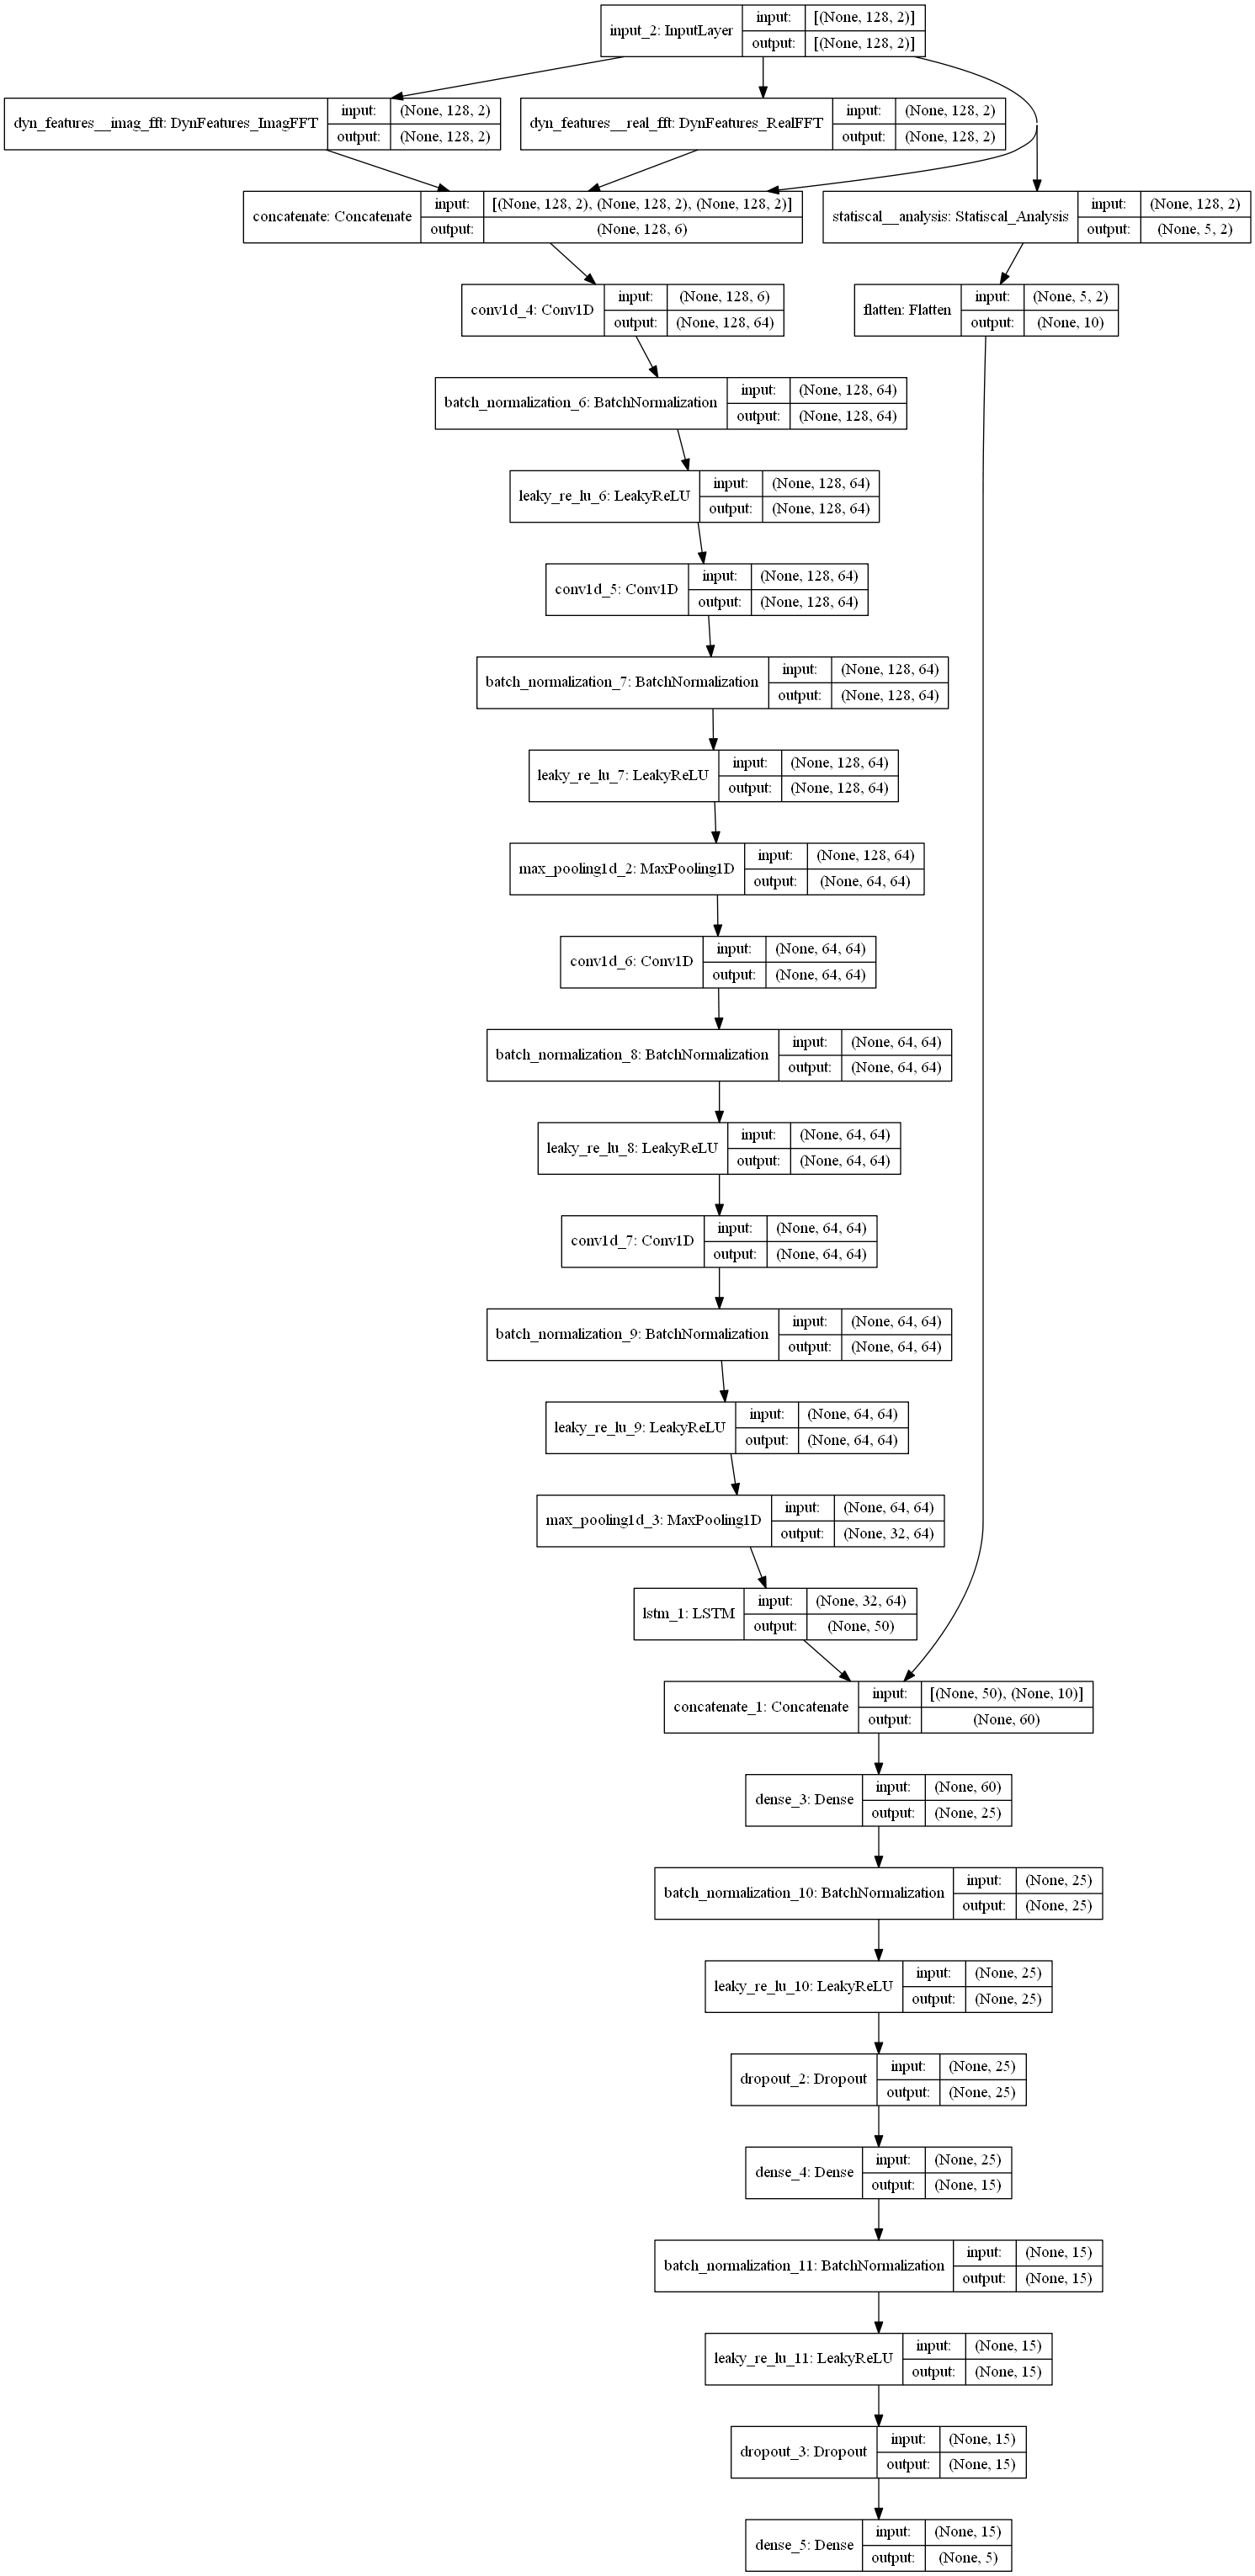

In [28]:
def Convolutional_LSTM_WITHOUT_CWT(filters=64, kernel_size=17):

  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)

  x = keras.layers.Conv1D(filters, kernel_size, padding = 'same', use_bias=False)(Dynamic_Features)  # Conv1D(filter, kernel, padding, activation...), common settings : filter num of (power of 2)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)

  x = keras.layers.Conv1D(filters, kernel_size, padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.MaxPool1D(pool_size=2)(x)

  x = keras.layers.Conv1D(filters, int(np.ceil(kernel_size/2)), padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)

  x = keras.layers.Conv1D(filters, int(np.ceil(kernel_size/2)), padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  
  
  x = keras.layers.LSTM(50, activation='tanh')(x) # 통계랑이 batch 단위로 계산되기 때문에, batchnorm은 필요 없음.
  x = keras.layers.Concatenate()([x, Statistical_Features])

  x = keras.layers.Dense(units = 25, activation = None, kernel_initializer = 'he_normal', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.Dropout(0.3)(x)

  x = keras.layers.Dense(units = 15, activation = None, kernel_initializer = 'he_normal', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.Dropout(0.3)(x)
  
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
  
CLSTM_WITHOUT_CWT = Convolutional_LSTM_WITHOUT_CWT()
keras.utils.plot_model(CLSTM_WITHOUT_CWT, show_shapes=True)

In [29]:
%%time
CLSTM_WITHOUT_CWT.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.SparseCategoricalCrossentropy(),                                                                              
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

hist2 = CLSTM_WITHOUT_CWT.fit(Train_Dataset, epochs = epochs, shuffle = True, validation_data = Valid_Dataset, callbacks = [callbacks])

Epoch 1/20
7085/7085 [==============================] - 118s 15ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.0121 - val_sparse_categorical_accuracy: 0.9981
Epoch 2/20
7085/7085 [==============================] - 121s 16ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0050 - val_sparse_categorical_accuracy: 0.9986
Epoch 3/20
7085/7085 [==============================] - 117s 15ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.0095 - val_sparse_categorical_accuracy: 0.9984
Epoch 4/20
7085/7085 [==============================] - 118s 15ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9991 - val_loss: 9.6011e-04 - val_sparse_categorical_accuracy: 0.9999
Epoch 5/20
7085/7085 [==============================] - 119s 15ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0043 - val_sparse_categorical_accuracy: 0.9987
Epoch 6/20
7085/7085 [==============================] - 131s 17ms/step 

## 2. CLSTM with CWT

In [30]:
# Reference - https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer/notebook
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# tf.experimental.numpy.kron does not work on windows, use numpy.kron directly through a tf.numpy_function() wrapper
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt

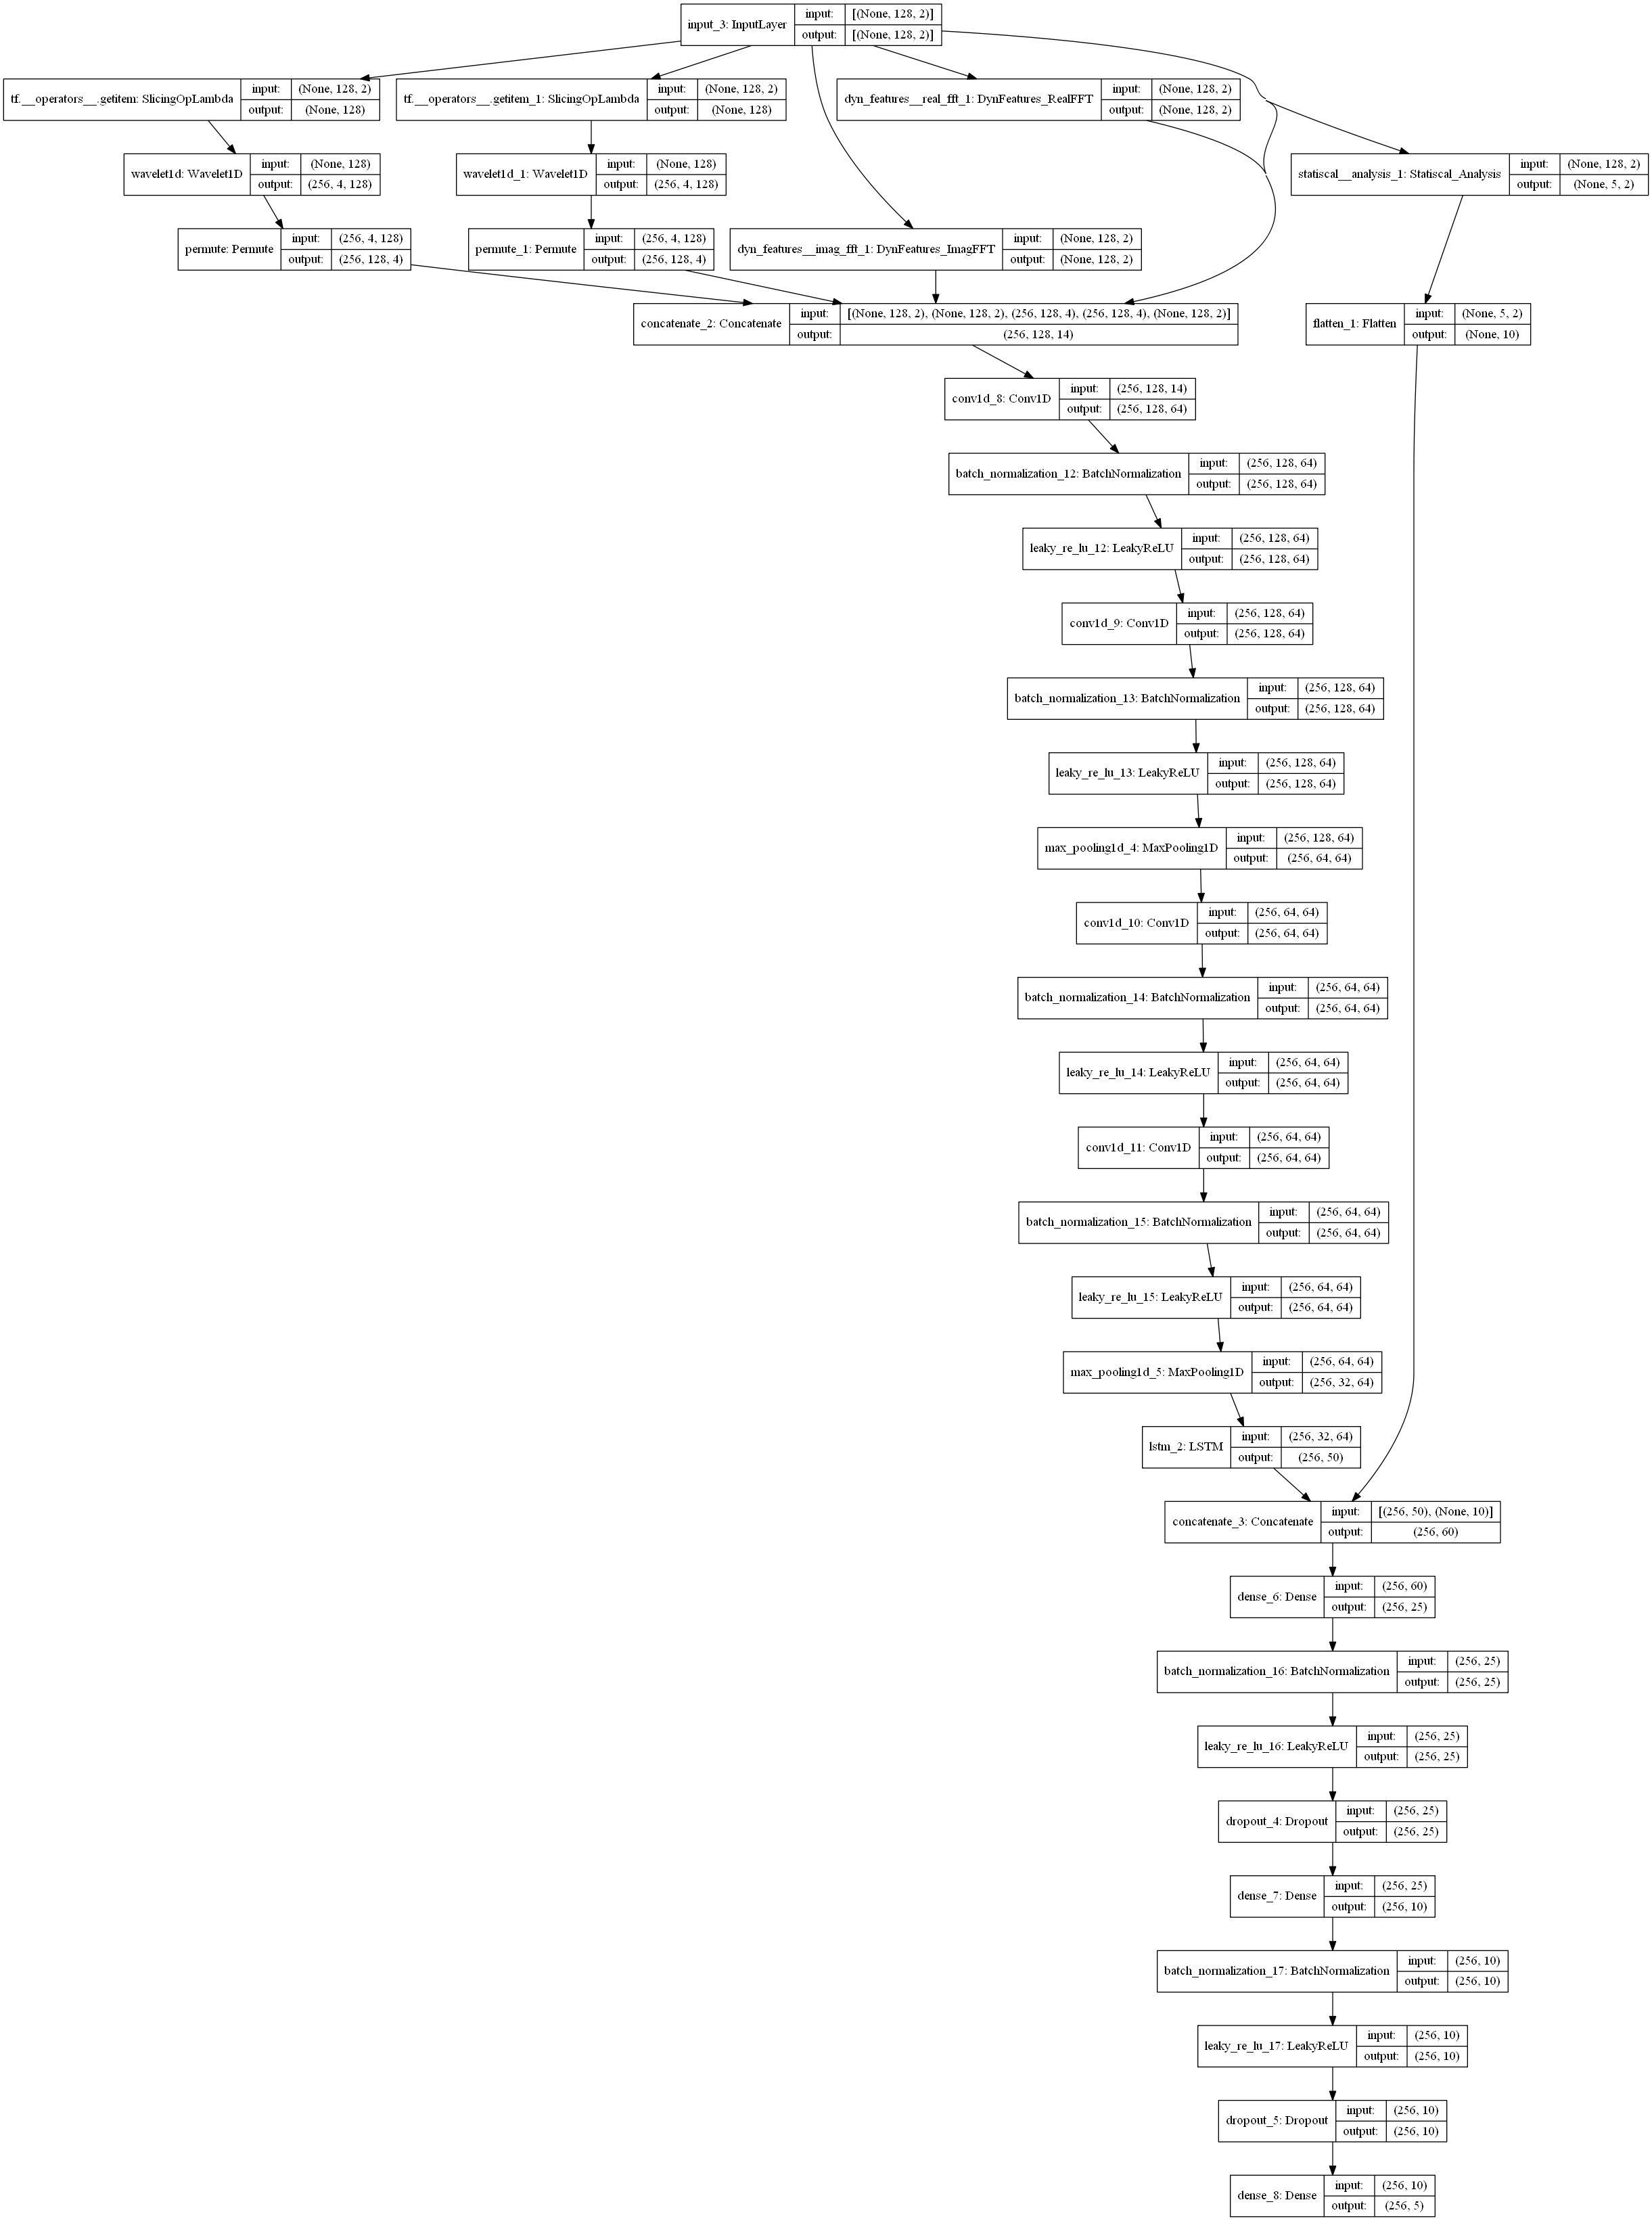

In [31]:
def Convolutional_LSTM(filters = 64, kernel_size= 17):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  c1 = Wavelet1D(batch_size = batchsize, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  c1 = keras.layers.Permute((2,1), input_shape=(batchsize, 128))(c1)
  c2 = Wavelet1D(batch_size = batchsize, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  c2 = keras.layers.Permute((2,1), input_shape=(batchsize, 128))(c2)
  
  Dynamic_Features = keras.layers.Concatenate()([i,r,c1,c2,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(filters, kernel_size, padding = 'same', use_bias=False)(Dynamic_Features)  # Conv1D(filter, kernel, padding, activation...)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)

  x = keras.layers.Conv1D(filters, kernel_size, padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.MaxPool1D(pool_size=2)(x)

  x = keras.layers.Conv1D(filters, int(np.ceil(kernel_size/2)), padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)

  x = keras.layers.Conv1D(filters, int(np.ceil(kernel_size/2)), padding = 'same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  
  
  x = keras.layers.LSTM(50, activation='tanh')(x) 
  x = keras.layers.Concatenate()([x, Statistical_Features])

  x = keras.layers.Dense(units = 25, activation = None, kernel_initializer = 'he_normal', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.Dropout(0.3)(x)

  x = keras.layers.Dense(units = 10, activation = None, kernel_initializer = 'he_normal', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.1)(x)
  x = keras.layers.Dropout(0.3)(x)
  
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)

  return model
  
CLSTM_WITH_CWT = Convolutional_LSTM()
keras.utils.plot_model(CLSTM_WITH_CWT, show_shapes=True)

In [32]:
%%time
CLSTM_WITH_CWT.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.SparseCategoricalCrossentropy(),                                                                              
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

hist3 = CLSTM_WITH_CWT.fit(Train_Dataset, epochs = epochs, shuffle = True, validation_data = Valid_Dataset, callbacks = [callbacks])

Epoch 1/20
7085/7085 [==============================] - 1446s 202ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.1292 - val_sparse_categorical_accuracy: 0.9732
Epoch 2/20
7085/7085 [==============================] - 1443s 202ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 0.9987
Epoch 3/20
7085/7085 [==============================] - 1409s 197ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0754 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/20
7085/7085 [==============================] - 1440s 202ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0380 - val_sparse_categorical_accuracy: 0.9954
Epoch 5/20
7085/7085 [==============================] - 1477s 207ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0140 - val_sparse_categorical_accuracy: 0.9981
Epoch 6/20
7085/7085 [==============================] - 1477s 207

# Evalutation

In [168]:
test_Dataset = TEST_Dataset_Constructor(final).batch(batchsize, drop_remainder=False)
print(test_Dataset.cardinality)

<bound method DatasetV2.cardinality of <BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>>


In [169]:
pred = vanilla.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\subs\model_naive_JS.csv', index = False)
sub.hist()

ValueError: Must have equal len keys and value when setting with an iterable

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

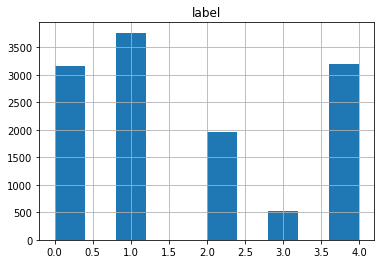

In [147]:
pred=CLSTM_WITHOUT_CWT.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\subs\model_CLSTM_WITHOUT_CWT_JS.csv', index = False)
sub.hist()

In [1]:
pred=CLSTM_WITH_CWT.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\subs\model_CLSTM_WITH_CWT_JS.csv', index = False)
sub.hist()

NameError: name 'CLSTM_WITH_CWT' is not defined

In [158]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["sparse_categorical_accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_sparse_categorical_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

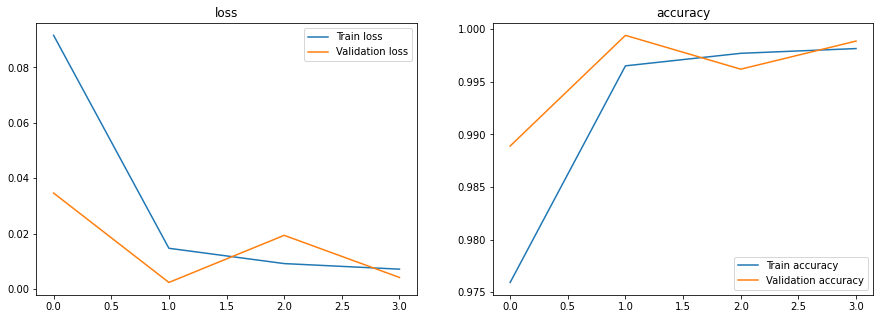

In [ ]:
show_final_history(hist1)

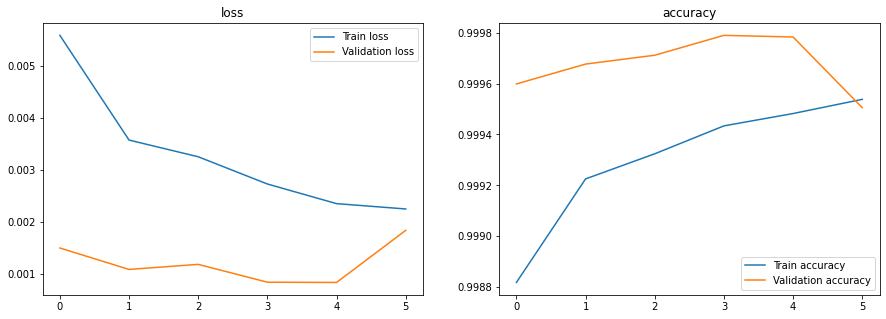

In [ ]:
show_final_history(hist2)

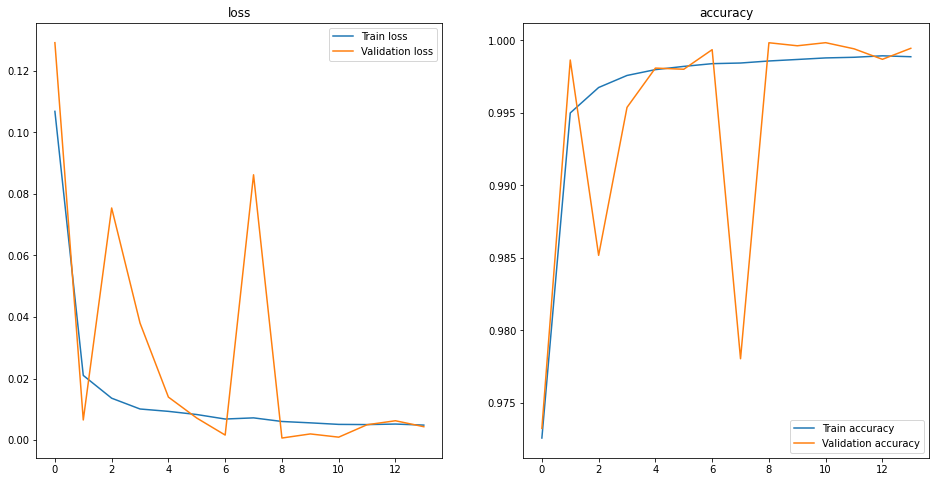

In [159]:
show_final_history(hist3)